In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%env HOME=/content/drive/My Drive/
%cd ~/
%cd GRQ


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env: HOME=/content/drive/My Drive/
/content/drive/My Drive
/content/drive/My Drive/GRQ


In [ ]:
!nvidia-smi
!pip install torch torchvision -U

Sun May  5 13:51:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              32W /  70W |   2153MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

!pip install "monai[einops]"

print(torch.cuda.is_available())
print(torch.__version__)
torch.device("cuda")

True
2.3.0+cu121


device(type='cuda')

In [ ]:
import math
from inspect import isfunction # inspect模块https://www.cnblogs.com/yaohong/p/8874154.html主要提供了四种用处：1.对是否是模块、框架、函数进行类型检查 2.获取源码 3.获取类或者函数的参数信息 4.解析堆栈
from functools import partial # 偏函数 https://www.runoob.com/w3cnote/python-partial.html

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 进度条
from einops import rearrange # einops把张量的维度操作具象化，让开发者“想出即写出"

import torch
from torch import nn, einsum # einsum很方便的实现复杂的张量操作 https://zhuanlan.zhihu.com/p/361209187
import torch.nn.functional as F

一些辅助性的小函数

In [ ]:
# x是否为None，不是None则返回True，是None则返回False
def exists(x):
    return x is not None

# 如果val非None则返回val，否则(如果d为函数则返回d(),否则返回d)
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# 残差连接
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__() #继承了nn.Module里所有的方法
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# 上采样
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# 下采样
def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [ ]:
# 一种位置编码，前一半sin后一半cos
# eg：维数dim=5，time取1和2两个时间
# layer = SinusoidalPositionEmbeddings(5)
# embeddings = layer(torch.tensor([1,2]))
# return embeddings的形状是(2,5),第一行是t=1时的位置编码，第二行是t=2时的位置编码
# 额外连接(transformer原作位置编码实现)：https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
# Block类，先卷积后GN归一化后siLU激活函数，若存在scale_shift则进行一定变换
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out) #GN归一化： 全缩到0-1之前 https://zhuanlan.zhihu.com/p/177853578
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

#例：dim=8，dim_out=16,time_emb_dim=2, groups=8
#Block = ResnetBlock(8, 16, time_emb_dim=2, groups=8)
#a = torch.ones(1, 8, 64, 64)
#b = torch.ones(1, 2)
#result = Block(a, b)
class ResnetBlock(nn.Module): # resnet: 强大的多层的CNN，很多归一激活什么的，
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        # 如果time_emb_dim存在则有mlp层
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity() #nn.Identity()有 https://blog.csdn.net/artistkeepmonkey/article/details/115067356

    def forward(self, x, time_emb=None):
        h = self.block1(x) # torch.Size([1, 16, 64, 64])

        if exists(self.mlp) and exists(time_emb):
            # time_emb为torch.Size([1, 2])
            time_emb = self.mlp(time_emb) # torch.Size([1, 16])
            # rearrange(time_emb, "b c -> b c 1 1")为torch.Size([1, 16, 1, 1])
            h = rearrange(time_emb, "b c -> b c 1 1") + h # torch.Size([1, 16, 64, 64])


        h = self.block2(h) # torch.Size([1, 16, 64, 64])
        return h + self.res_conv(x) # return最后补了残差连接 # torch.Size([1, 16, 64, 64])

# 可以参考class ResnetBlock进行理解
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        # 如果time_emb_dim存在则有mlp层
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(), # Gaussian Error Linear Unit
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

Attention流程图
![%E6%9C%AA%E5%91%BD%E5%90%8D%E6%96%87%E4%BB%B6%20%281%29.png](attachment:%E6%9C%AA%E5%91%BD%E5%90%8D%E6%96%87%E4%BB%B6%20%281%29.png)

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)# qkv为一个元组，其中每一个元素的大小为torch.Size([b, hidden_dim, h, w])
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        ) # qkv中每个元素从torch.Size([b, hidden_dim, h, w])变为torch.Size([b, heads, dim_head, h*w])
        q = q * self.scale # q扩大dim_head**-0.5倍

        sim = einsum("b h d i, b h d j -> b h i j", q, k) # sim有torch.Size([b, heads, h*w, h*w])
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1) # attn有torch.Size([b, heads, h*w, h*w])

        out = einsum("b h i j, b h d j -> b h i d", attn, v) # [b, heads, h*w, h*w]和[b, heads, dim_head, h*w] 得 out为[b, heads, h*w, dim_head]
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w) # 得out为[b, hidden_dim, h, w]
        return self.to_out(out) # 得 [b, dim, h, w]

# 和class Attention几乎一致
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [ ]:
# 先norm后fn
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim, # 下例中，dim=image_size=28
        init_dim=None,# 默认为None，最终取dim // 3 * 2
        out_dim=None, # 默认为None，最终取channels
        dim_mults=(1,2,4,8),
        channels=3, # 通道数默认为3
        with_time_emb=True, # 是否使用embeddings
        resnet_block_groups=8, # 如果使用ResnetBlock，groups=resnet_block_groups
        use_convnext=True, # 是True使用ConvNextBlock，是Flase使用ResnetBlock
        convnext_mult=2, # 如果使用ConvNextBlock，mult=convnext_mult
    ):
        super().__init__()
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # 从头到尾dim组成的列表
        in_out = list(zip(dims[:-1], dims[1:])) # dim对组成的列表
        # 使用ConvNextBlock或ResnetBlock
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([]) # 初始化下采样网络列表
        self.ups = nn.ModuleList([]) # 初始化上采样网络列表
        num_resolutions = len(in_out) # dim对组成的列表的长度

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1) # 是否到了最后一对

            self.downs.append(
                nn.ModuleList(
                [
                    block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                    block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                    Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                    Downsample(dim_out) if not is_last else nn.Identity(),
                ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim,time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

四种beta选择

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

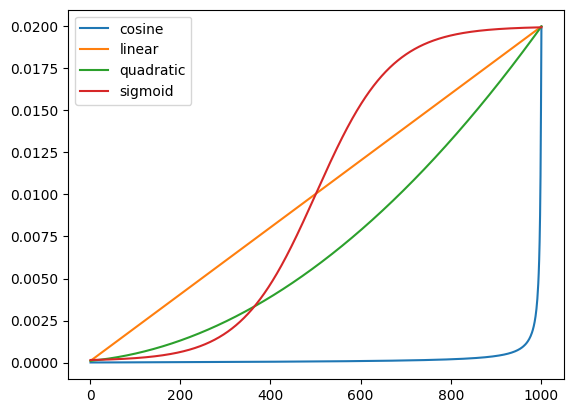

In [ ]:
import numpy as np
x = np.linspace(1,1001,1000)
timesteps = 1000

fig, ax = plt.subplots() # 创建图实例
ax.plot(x, (cosine_beta_schedule(timesteps, s=0.008)/50).numpy(), label='cosine')
ax.plot(x, linear_beta_schedule(timesteps).numpy(), label='linear')
ax.plot(x, quadratic_beta_schedule(timesteps).numpy(), label='quadratic')
ax.plot(x, sigmoid_beta_schedule(timesteps).numpy(), label='sigmoid')
plt.legend()
plt.show()

betas：$\beta$

alphas：$\alpha = 1-\beta$

alphas_cumprod：$\overline{\alpha_t} = \prod_{s=1}^{t}\alpha_s$

alphas_cumprod_prev:$\overline{\alpha_{t-1}}$

sqrt_recip_alphas: $1/\sqrt{\overline{\alpha_t}}$

sqrt_alphas_cumprod: $\sqrt{\overline{\alpha_t}}$

sqrt_one_minus_alphas_cumprod: $\sqrt{1-\overline{\alpha_t}}$

posterior_variance: $\beta * (1-\overline{\alpha_{t-1}}) / (1-\overline{\alpha_{t}})$

In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# sqrt_alphas_cumprod = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# x_start = torch.ones([1, 3, 8, 8])
# out = extract(a=sqrt_alphas_cumprod, t=torch.tensor([5]), x_shape=x_start.shape)
# print(out.shape)
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# 随便导入一个图片
from google.colab import drive

from google.colab import drive
from PIL import Image
from IPython.display import display



In [ ]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0) # torch.manual_seed(0)

# pytorch官方的一个画图函数
# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    plt.show()

In [ ]:
# 三种损失函数有l1，l2和huber，默认为l1
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
!pip install datasets
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
image_size = 28
channels = 1
batch_size = 128

In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from datasets import load_dataset

# # Assuming the dataset is loaded as before
# dataset = load_dataset("fashion_mnist", split='train')

# def show_images(dataset, examples=9):
#     plt.figure(figsize=(10, 10))
#     for i, sample in enumerate(dataset):
#         if i == examples: break
#         plt.subplot(3, 3, i+1)
#         # Assuming 'image' is the key where the image data is stored
#         # and converting it to a PIL Image for display
#         image = Image.fromarray(sample['image'].np())
#         plt.imshow(image, cmap='gray')  # Display the image
#         plt.axis('off')
#     plt.show()

# show_images(dataset)

!pip install datasets
from datasets import load_dataset
dataset_name='mnist'
# load dataset from the hub
dataset = load_dataset(dataset_name)
image_size = 28
channels = 1
batch_size = 128

1. plot the images
2. start with the easy ones
3. hyperparameters online
4. go back to fasion


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize


# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

# 得到变换之后的数据集
transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

$
\begin{aligned}
\tilde{\boldsymbol{\mu}}_{t} &=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \mathbf{z}_{t}\right)
\end{aligned}
$
其中，$z_t$由model(x,t)得

In [ ]:
@torch.no_grad() #我这时候不做梯度
def p_sample(model, x, t, t_index):
    # p_sample(model, img, torch.full((b,),i,device=device,dtype=torch.long),i)
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else: # 加一定的噪声
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model, shape):
    # 从噪声中逐步采样
    device = next(model.parameters()).device

    b = shape[0]

    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step',total=timesteps):
        img = p_sample(model, img, torch.full((b,),i,device=device,dtype=torch.long),i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model,shape=(batch_size,channels, image_size, image_size))

In [ ]:
from pathlib import Path
# 例如num = 10， divisor = 3，得[3,3,3,1]
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [ ]:
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True) # https://zhuanlan.zhihu.com/p/317254621
save_and_sample_every = 1000

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels = channels,
    dim_mults=(1,2,4)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=5e-4)

Run 0:   0%|          | 0/15 [00:00<?, ?it/s]

Run 0, Epoch 0, Step 0, Loss: 0.48088663816452026



Run 0:   7%|▋         | 1/15 [01:22<19:08, 82.04s/it]

Run 0, Epoch 1, Step 0, Loss: 0.0029009191785007715



Run 0:  13%|█▎        | 2/15 [02:45<18:00, 83.13s/it]

Run 0, Epoch 2, Step 0, Loss: 0.000807069125585258



Run 0:  20%|██        | 3/15 [04:08<16:35, 82.94s/it]

Run 0, Epoch 3, Step 0, Loss: 0.0004389135865494609



Run 0:  27%|██▋       | 4/15 [05:31<15:11, 82.86s/it]

Run 0, Epoch 4, Step 0, Loss: 0.00027076067635789514



Run 0:  33%|███▎      | 5/15 [06:54<13:47, 82.77s/it]

Run 0, Epoch 5, Step 0, Loss: 0.00019167509162798524



Run 0:  40%|████      | 6/15 [08:15<12:21, 82.38s/it]

Run 0, Epoch 6, Step 0, Loss: 0.00015964647172950208



Run 0:  47%|████▋     | 7/15 [09:37<10:58, 82.36s/it]

Run 0, Epoch 7, Step 0, Loss: 0.00014357507461681962



Run 0:  53%|█████▎    | 8/15 [11:00<09:37, 82.44s/it]

Run 0, Epoch 8, Step 0, Loss: 0.00010618841770337895



Run 0:  60%|██████    | 9/15 [12:22<08:13, 82.30s/it]

Run 0, Epoch 9, Step 0, Loss: 8.350921416422352e-05



Run 0:  67%|██████▋   | 10/15 [13:45<06:51, 82.40s/it]

Run 0, Epoch 10, Step 0, Loss: 7.185473805293441e-05



Run 0:  73%|███████▎  | 11/15 [15:07<05:29, 82.42s/it]

Run 0, Epoch 11, Step 0, Loss: 0.00011527815513545647



Run 0:  80%|████████  | 12/15 [16:29<04:07, 82.38s/it]

Run 0, Epoch 12, Step 0, Loss: 5.254869756754488e-05



Run 0:  87%|████████▋ | 13/15 [17:53<02:45, 82.74s/it]

Run 0, Epoch 13, Step 0, Loss: 4.7022997023304924e-05



Run 0:  93%|█████████▎| 14/15 [19:16<01:22, 82.74s/it]

Run 0, Epoch 14, Step 0, Loss: 9.249701543012634e-05



Run 0: 100%|██████████| 15/15 [20:38<00:00, 82.58s/it]


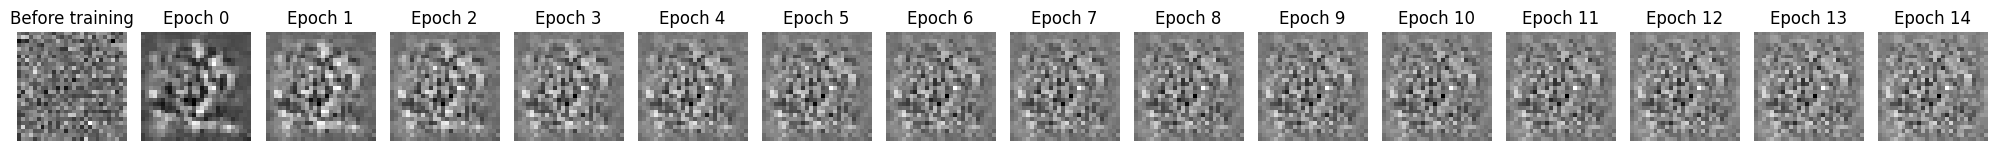

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 5e-4
epochs = 15
timesteps = 200  # Adjust according to your settings
save_and_sample_every = 500  # Adjust according to your settings
runs = 1  # Number of runs with different seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_index=10
# Function to train the model and return the losses
def train_model_with_seed(seed, randint_seed, run):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4))
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    samples_per_epoch = []  # List to store samples for each epoch

    # Generate sample before training and store it
    initial_sample = sample(model, image_size=image_size, batch_size=64, channels=channels)
    samples_per_epoch.append(("Before training", initial_sample[-1][random_index]))

    for epoch in tqdm(range(epochs), desc=f'Run {seed}'):
        epoch_loss = []

        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()

            batch_size = batch["pixel_values"].shape[0]
            batch = batch["pixel_values"].to(device)

            # Set a specific seed for torch.randint
            torch.manual_seed(randint_seed)
            t = torch.randint(0, timesteps, (batch_size,), device=device).long()

            loss = p_losses(model, batch, t, loss_type="huber")

            if step % 1000 == 0:
                print(f"Run {run}, Epoch {epoch}, Step {step}, Loss: {loss.item()}")

            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        # Generate and store samples at the end of each epoch
        samples = sample(model, image_size=image_size, batch_size=64, channels=channels)
        samples_per_epoch.append((f'Epoch {epoch}', samples[-1][random_index]))  # Store the sample of interest

        # Record the average loss per epoch
        loss_history.append(np.mean(epoch_loss))

    # Save the trained model after all epochs
    torch.save(model.state_dict(), 'model_' + dataset_name + '.pt')

    # Plot all samples after training
    n_cols = len(samples_per_epoch)
    fig, axs = plt.subplots(1, n_cols, figsize=(20, 4))  # Adjust row size for single row

    for i, (title, s) in enumerate(samples_per_epoch):
        ax = axs[i]
        ax.imshow(s.reshape(image_size, image_size, channels), cmap="gray")
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return loss_history

# Collecting results from multiple runs
all_loss_histories = []

for seed in range(runs):
    randint_seed = seed * 1000  # Multiply seed to ensure unique randint seed
    losses = train_model_with_seed(seed, randint_seed,seed)
    all_loss_histories.append(losses)
#----------IF WANNA SAVE THIS TRAINING'S LOSS Histories------------
# with open('loss_histories.pkl', 'wb') as f:
    # pickle.dump(all_loss_histories, f)s


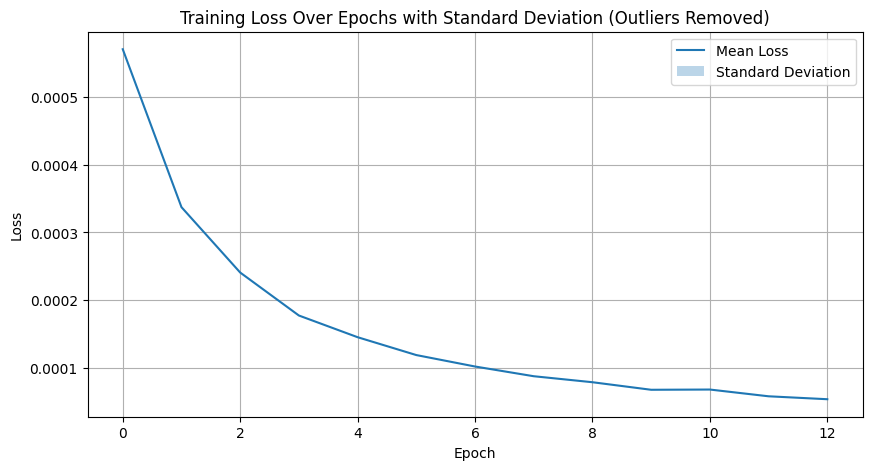

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt



# -------------IF WANNA LOAD EXISTING LOSS HISTORIES----------
# with open('loss_histories.pkl', 'rb') as f:
#     all_loss_histories = pickle.load(f)
# -------------IF WANNA LOAD EXISTING LOSS HISTORIES----------




# Function to remove outliers using the IQR method
def remove_outliers(data):
    data = np.array(data)  # Ensure it's a NumPy array
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers from each run's loss data
filtered_loss_histories = []
for run in all_loss_histories:
    filtered_run = remove_outliers(run)
    filtered_loss_histories.append(filtered_run)

# Align the lengths of filtered loss histories by trimming or padding
max_length = min(map(len, filtered_loss_histories))  # Take the minimum length
aligned_loss_histories = np.array([run[:max_length] for run in filtered_loss_histories])

# Compute the average and standard deviation
mean_losses = np.mean(aligned_loss_histories, axis=0)
std_losses = np.std(aligned_loss_histories, axis=0)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(mean_losses.shape[0]), mean_losses, label='Mean Loss')
plt.fill_between(range(mean_losses.shape[0]), mean_losses - std_losses, mean_losses + std_losses, alpha=0.3, label='Standard Deviation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs with Standard Deviation (Outliers Removed)')
plt.legend()
plt.grid(True)
plt.show()


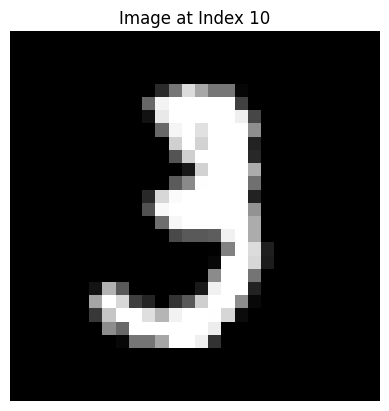

In [ ]:
# show the original image

def display_image_at_index(index=0):
    """Display the image at the given index from the MNIST dataset."""
    # Access the image data
    image_data = dataset['train'][index]['image']

    # If the 'image' is a PIL Image, convert it to a numpy array
    if not isinstance(image_data, np.ndarray):
        image_data = np.array(image_data)

    # Display the image
    plt.imshow(image_data.squeeze(), cmap='gray')  # Use squeeze in case the image has an extra singleton dimension
    plt.title(f'Image at Index {index}')
    plt.axis('off')  # Optionally remove the axes
    plt.show()

random_index = 10
display_image_at_index(random_index)

In [ ]:
# sample 64 images
model_to_sample = Unet(
    dim=image_size,
    channels = channels,
    dim_mults=(1,2,4)
)
model_to_sample.load_state_dict(torch.load('test_mnist.pt'))
model_to_sample.to(device)


samples = sample(model_to_sample, image_size=image_size, batch_size=64, channels=channels)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

In [ ]:
# 展示从噪声生成图像的过程
!pip install pillow

import matplotlib.animation as animation
random_index = 10
fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif', writer='pillow')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#---------------------DENOISING PROCESS--------------------

# Sample constants (adjust according to your data)
timesteps = 200  # Total number of timesteps (adjust as needed)
image_size = 28  # Image size (adjust as needed)
channels = 1  # Number of image channels, 1 for grayscale, 3 for RGB
random_index = 0  # The index of the specific sample to visualize
# Set up the number of images per row and total rows based on the total number of timesteps
n_cols = 10
n_rows = (timesteps + n_cols - 1) // n_cols  # Ceiling division for rows

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))  # Adjust the figsize as needed

for i in range(timesteps):
    row, col = divmod(i, n_cols)  # Calculate row and column indices
    ax = axs[row, col]

    # Adjust image extraction and reshaping based on the actual data
    if channels == 1:
        img = samples[i][random_index].reshape(image_size, image_size)
        ax.imshow(img, cmap="gray")
    else:
        img = samples[i][random_index].reshape(image_size, image_size, channels)
        ax.imshow(img)

    ax.set_title(f'Timestep {i}')
    ax.axis('off')

# Remove any empty plots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#----------------EVERY 10 TIME STEPS--------------

# Constants (adjust according to your data)
timesteps = 200  # Total number of timesteps
image_size = 28  # Image size
channels = 1  # Number of image channels (1 for grayscale, 3 for RGB)
random_index = 0  # Index of the sample to visualize

# Determine which timesteps to visualize (every 10 timesteps)
steps_to_plot = range(0, timesteps, 10)
n_images = len(steps_to_plot)

# Set up the number of images per row and total rows based on the selected timesteps
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division for rows

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))  # Adjust figsize as needed

for idx, i in enumerate(steps_to_plot):
    row, col = divmod(idx, n_cols)  # Calculate row and column indices
    ax = axs[row, col]

    # Adjust image extraction and reshaping based on the actual data
    if channels == 1:
        img = samples[i][random_index].reshape(image_size, image_size)
        ax.imshow(img, cmap="gray")
    else:
        img = samples[i][random_index].reshape(image_size, image_size, channels)
        ax.imshow(img)

    ax.set_title(f'Timestep {i}')
    ax.axis('off')

# Remove any empty plots
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()
